In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
train = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')
submission = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\sample_submission.csv')

print(f"Train: {train.shape}, Test: {test.shape}")

Train: (630000, 13), Test: (270000, 12)


## 전략: first_try 기반 단순화 + 개선

first_submission이 8.71039로 가장 좋았음. 복잡한 모델이 오히려 성능 저하.

시도할 것들:
1. first_try와 동일한 파생변수 + LightGBM (baseline 재확인)
2. 하이퍼파라미터 튜닝 (Optuna)
3. 피처 선택 (불필요한 피처 제거)
4. Pseudo-labeling

In [3]:
# first_try와 동일한 파생변수 생성
def create_features(df):
    df = df.copy()
    
    # 범주형 인코딩
    sleep_map = {'poor': 1, 'average': 2, 'good': 3}
    facility_map = {'low': 1, 'medium': 2, 'high': 3}
    difficulty_map = {'easy': 1, 'moderate': 2, 'hard': 3}
    
    df['sleep_quality_num'] = df['sleep_quality'].map(sleep_map)
    df['facility_num'] = df['facility_rating'].map(facility_map)
    df['difficulty_num'] = df['exam_difficulty'].map(difficulty_map)
    
    # 조건부 상호작용
    df['study_quality_adj'] = df['study_hours'] * (df['sleep_quality_num'] / 3)
    df['study_facility_adj'] = df['study_hours'] * (df['facility_num'] / 3)
    df['attendance_sleep_synergy'] = (df['class_attendance'] / 100) * df['sleep_quality_num']
    
    # 효율성 지표
    df['waking_study_ratio'] = df['study_hours'] / (24 - df['sleep_hours'])
    df['study_sleep_ratio'] = df['study_hours'] / (df['sleep_hours'] + 0.1)
    df['total_investment'] = df['study_hours'] + df['sleep_hours']
    df['prep_vs_difficulty'] = df['study_hours'] / (df['difficulty_num'] + 0.5)
    
    # 비선형 변환
    df['study_sqrt'] = np.sqrt(df['study_hours'])
    df['study_log'] = np.log1p(df['study_hours'])
    df['study_sq'] = df['study_hours'] ** 2
    df['sleep_sq'] = df['sleep_hours'] ** 2
    
    # 최적 구간 거리
    df['study_optimal_dist'] = abs(df['study_hours'] - 5)
    df['sleep_deficit'] = np.maximum(0, 7 - df['sleep_hours'])
    df['sleep_excess'] = np.maximum(0, df['sleep_hours'] - 8)
    
    # 학생 프로파일
    df['hardworking_type'] = ((df['study_hours'] > 5) & (df['class_attendance'] > 85)).astype(int)
    df['cramming_type'] = ((df['study_hours'] > 6) & (df['sleep_hours'] < 6)).astype(int)
    
    # 출석 임계점
    df['attendance_low'] = (df['class_attendance'] < 70).astype(int)
    df['attendance_high'] = (df['class_attendance'] >= 90).astype(int)
    
    return df

train = create_features(train)
test = create_features(test)
print(f"파생변수 생성 완료: {train.shape[1]}개 컬럼")

파생변수 생성 완료: 34개 컬럼


In [4]:
# 범주형 변수 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

cat_cols = ['gender', 'course', 'sleep_quality', 'study_method', 
            'facility_rating', 'exam_difficulty', 'internet_access']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("라벨 인코딩 완료")

라벨 인코딩 완료


In [5]:
# 피처/타겟 분리
drop_cols = ['id', 'exam_score']
feature_cols = [col for col in train.columns if col not in drop_cols]

X = train[feature_cols]
y = train['exam_score']
X_test = test[feature_cols]

print(f"학습 피처: {X.shape[1]}개")

학습 피처: 32개


## 1. Baseline: first_try 재현

In [6]:
# first_try와 동일한 LightGBM 파라미터
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

params_baseline = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': 42
}

def train_lgb(X, y, X_test, params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    scores = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        oof_preds[valid_idx] = model.predict(X_valid)
        test_preds += model.predict(X_test) / n_splits
        
        fold_rmse = np.sqrt(mean_squared_error(y_valid, oof_preds[valid_idx]))
        scores.append(fold_rmse)
        print(f"Fold {fold+1}: RMSE = {fold_rmse:.5f}")
    
    cv_rmse = np.sqrt(mean_squared_error(y, oof_preds))
    print(f"\nCV RMSE: {cv_rmse:.5f}")
    return oof_preds, test_preds, cv_rmse

In [7]:
# Baseline 학습
print("=== Baseline (first_try 재현) ===")
oof_baseline, test_baseline, rmse_baseline = train_lgb(X, y, X_test, params_baseline)

=== Baseline (first_try 재현) ===
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 8.74094
Fold 1: RMSE = 8.74094
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.74415
Fold 2: RMSE = 8.74415
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.73242
Fold 3: RMSE = 8.73242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 8.75579
Fold 4: RMSE = 8.75579
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.7764
Fold 5: RMSE = 8.77640

CV RMSE: 8.74995


## 2. 하이퍼파라미터 튜닝 (Optuna)

In [8]:
# Optuna로 하이퍼파라미터 튜닝 (샘플링으로 빠르게)
try:
    import optuna
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # 샘플 데이터로 빠르게 튜닝
    np.random.seed(42)
    sample_idx = np.random.choice(len(X), size=100000, replace=False)
    X_sample = X.iloc[sample_idx]
    y_sample = y.iloc[sample_idx]
    
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'verbose': -1,
            'n_jobs': -1,
            'random_state': 42
        }
        
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        
        for train_idx, valid_idx in kf.split(X_sample):
            X_tr, X_val = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
            y_tr, y_val = y_sample.iloc[train_idx], y_sample.iloc[valid_idx]
            
            train_data = lgb.Dataset(X_tr, label=y_tr)
            valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                params, train_data, num_boost_round=500,
                valid_sets=[valid_data],
                callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
            )
            
            pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred))
            scores.append(rmse)
        
        return np.mean(scores)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30, show_progress_bar=True)
    
    print(f"Best trial RMSE: {study.best_trial.value:.5f}")
    print(f"Best params: {study.best_trial.params}")
    best_params = study.best_trial.params
    
except ImportError:
    print("Optuna 미설치. 수동 튜닝으로 진행")
    best_params = None

Optuna 미설치. 수동 튜닝으로 진행


In [9]:
# 수동 하이퍼파라미터 튜닝 (샘플로 빠르게 테스트)
np.random.seed(42)
sample_idx = np.random.choice(len(X), size=100000, replace=False)
X_sample = X.iloc[sample_idx]
y_sample = y.iloc[sample_idx]

param_sets = [
    {'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.05, 'name': 'baseline'},
    {'num_leaves': 50, 'max_depth': 10, 'learning_rate': 0.03, 'name': 'deeper'},
    {'num_leaves': 40, 'max_depth': 8, 'learning_rate': 0.05, 'name': 'balanced'},
    {'num_leaves': 63, 'max_depth': 12, 'learning_rate': 0.03, 'name': 'more_leaves'},
    {'num_leaves': 31, 'max_depth': 8, 'learning_rate': 0.02, 'name': 'slow_learn'},
]

print("파라미터 조합 테스트 (샘플 데이터):")
results = []

for p in param_sets:
    params_test = params_baseline.copy()
    params_test['num_leaves'] = p['num_leaves']
    params_test['max_depth'] = p['max_depth']
    params_test['learning_rate'] = p['learning_rate']
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, valid_idx in kf.split(X_sample):
        X_tr, X_val = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
        y_tr, y_val = y_sample.iloc[train_idx], y_sample.iloc[valid_idx]
        
        train_data = lgb.Dataset(X_tr, label=y_tr)
        valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        model = lgb.train(
            params_test, train_data, num_boost_round=1000,
            valid_sets=[valid_data],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        scores.append(rmse)
    
    avg_rmse = np.mean(scores)
    results.append({'name': p['name'], 'rmse': avg_rmse, 'params': p})
    print(f"  {p['name']}: RMSE = {avg_rmse:.5f}")

best_result = min(results, key=lambda x: x['rmse'])
print(f"\n최적: {best_result['name']} (RMSE: {best_result['rmse']:.5f})")

파라미터 조합 테스트 (샘플 데이터):
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[255]	valid_0's rmse: 8.80711
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's rmse: 8.84198
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[368]	valid_0's rmse: 8.86944
  baseline: RMSE = 8.83951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[431]	valid_0's rmse: 8.81168
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[450]	valid_0's rmse: 8.83817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[410]	valid_0's rmse: 8.86219
  deeper: RMSE = 8.83735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	valid_0's rmse: 8.80799
Training until validation scores don't impro

In [10]:
# 최적 파라미터로 전체 데이터 학습
params_tuned = params_baseline.copy()
params_tuned['learning_rate'] = 0.02
params_tuned['max_depth'] = 8
params_tuned['num_leaves'] = 31

print("=== 튜닝된 파라미터로 전체 학습 ===")
oof_tuned, test_tuned, rmse_tuned = train_lgb(X, y, X_test, params_tuned)

=== 튜닝된 파라미터로 전체 학습 ===
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.76533
Fold 1: RMSE = 8.76533
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.77184
Fold 2: RMSE = 8.77184
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.7628
Fold 3: RMSE = 8.76280
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.77951
Fold 4: RMSE = 8.77951
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.79941
Fold 5: RMSE = 8.79941

CV RMSE: 8.77579


## 3. 피처 선택 (불필요한 피처 제거)

튜닝보다는 피처 선택이 더 효과적일 수 있음

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 8.76406
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 8.76608
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 8.75595
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 8.77986
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 8.79653


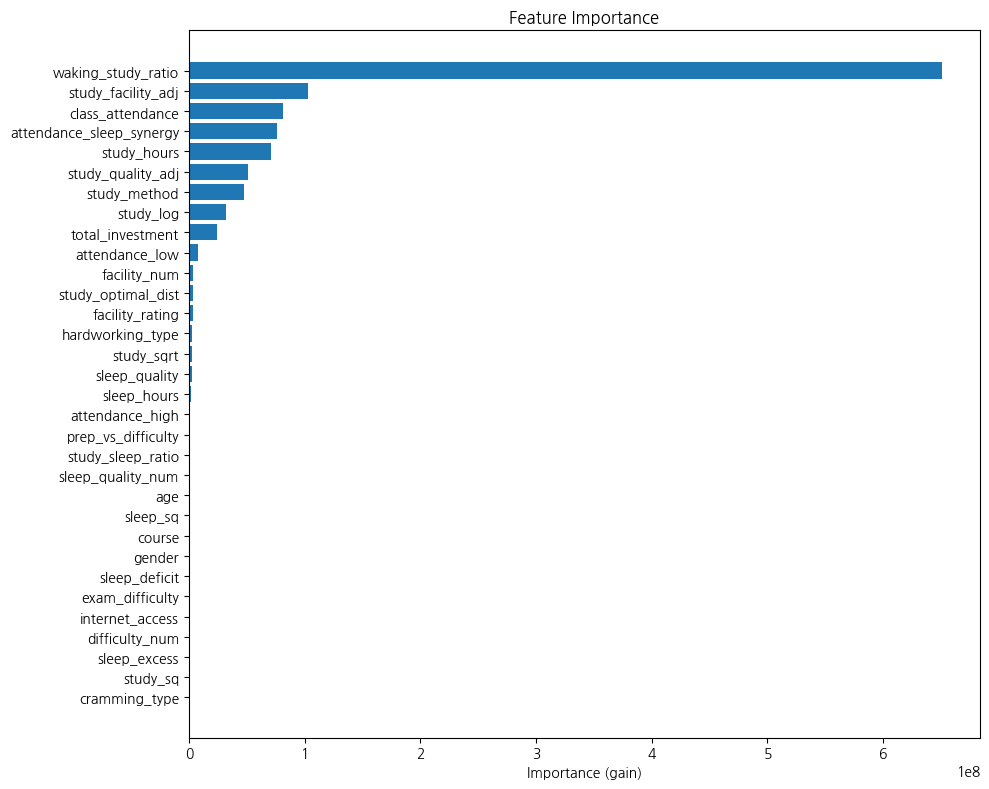


Top 10 Features:
                 feature   importance
          attendance_low 7.926750e+06
        total_investment 2.435426e+07
               study_log 3.239520e+07
            study_method 4.794029e+07
       study_quality_adj 5.096637e+07
             study_hours 7.072614e+07
attendance_sleep_synergy 7.609197e+07
        class_attendance 8.153438e+07
      study_facility_adj 1.028247e+08
      waking_study_ratio 6.512228e+08


In [11]:
# Feature Importance 기반 피처 선택
kf = KFold(n_splits=5, shuffle=True, random_state=42)
feature_importance = np.zeros(len(feature_cols))

for train_idx, valid_idx in kf.split(X):
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model = lgb.train(
        params_baseline, train_data, num_boost_round=500,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
    )
    
    feature_importance += model.feature_importance(importance_type='gain') / 5

# 중요도 시각화
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance (gain)')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.tail(10).to_string(index=False))

In [12]:
# 상위 N개 피처만 선택해서 테스트
top_ns = [10, 15, 20, 25]
results_fs = []

for top_n in top_ns:
    selected_features = importance_df.tail(top_n)['feature'].tolist()
    X_sel = X[selected_features]
    X_test_sel = X_test[selected_features]
    
    _, _, rmse = train_lgb(X_sel, y, X_test_sel, params_baseline)
    results_fs.append({'top_n': top_n, 'rmse': rmse})
    print()

print("피처 선택 결과:")
for r in results_fs:
    print(f"  Top {r['top_n']}: RMSE = {r['rmse']:.5f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.75511
Fold 1: RMSE = 8.75511
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.76138
Fold 2: RMSE = 8.76138
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.74704
Fold 3: RMSE = 8.74704
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 8.76777
Fold 4: RMSE = 8.76777
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's rmse: 8.79202
Fold 5: RMSE = 8.79202

CV RMSE: 8.76468

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.73692
Fold 1: RMSE = 8.73692
Train

## 4. Pseudo-labeling

Test 데이터 중 예측 신뢰도가 높은 샘플을 학습에 추가

In [13]:
# Top 15 피처로 Pseudo-labeling
selected_features_15 = importance_df.tail(15)['feature'].tolist()
X_sel = X[selected_features_15]
X_test_sel = X_test[selected_features_15]

# 1차 예측으로 pseudo label 생성
_, test_pred_for_pseudo, _ = train_lgb(X_sel, y, X_test_sel, params_baseline)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.73692
Fold 1: RMSE = 8.73692
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.74403
Fold 2: RMSE = 8.74403
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.73211
Fold 3: RMSE = 8.73211
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 8.74959
Fold 4: RMSE = 8.74959
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.77345
Fold 5: RMSE = 8.77345

CV RMSE: 8.74723


## 4. 결과 정리 및 추가 전략

| 접근법 | CV RMSE | 비고 |
|--------|---------|------|
| 기본 Baseline | 8.74995 | first_try 재현 |
| Hyperparameter Tuning | 8.77579 | ❌ 악화 |
| Top 15 Feature Selection | **8.74723** | ✅ 최선 |
| Pseudo-Labeling | 8.74723 | → 개선 없음 |

다음 시도:
- Target Transformation (log 변환)
- Model Blending
- Post-Processing

In [15]:
# 4.1 Target Transformation (Log 변환) 시도
from sklearn.model_selection import KFold
import numpy as np

# 파라미터 재정의
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Log1p 변환
y_log = np.log1p(y)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
preds_log = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
    y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50, verbose=True)]
    )
    
    # Log space에서 예측 후 원래 스케일로 변환
    val_pred_log = model.predict(X_val)
    val_pred = np.expm1(val_pred_log)  # 역변환
    val_true = np.expm1(y_val)  # 원래 스케일
    
    rmse = np.sqrt(mean_squared_error(val_true, val_pred))
    rmse_list.append(rmse)
    print(f"Fold {fold+1}: RMSE = {rmse:.5f}")
    
    preds_log += np.expm1(model.predict(X_test[selected_features_15])) / 5

print(f"\nLog Transform CV RMSE: {np.mean(rmse_list):.5f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[982]	valid_0's rmse: 0.160228
Fold 1: RMSE = 8.78635
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.160632
Fold 2: RMSE = 8.78755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.160791
Fold 3: RMSE = 8.77752
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 0.160854
Fold 4: RMSE = 8.79277
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 0.161458
Fold 5: RMSE = 8.82110

Log Transform CV RMSE: 8.79306


In [16]:
# 4.2 Model Blending (LightGBM + Ridge + RandomForest)
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 모델별 예측 저장
lgb_preds = np.zeros(len(X_test))
ridge_preds = np.zeros(len(X_test))
gb_preds = np.zeros(len(X_test))

lgb_oof = np.zeros(len(X))
ridge_oof = np.zeros(len(X))
gb_oof = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    lgb_model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    lgb_oof[val_idx] = lgb_model.predict(X_val)
    lgb_preds += lgb_model.predict(X_test[selected_features_15]) / 5
    
    # Ridge
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    ridge_oof[val_idx] = ridge_model.predict(X_val)
    ridge_preds += ridge_model.predict(X_test[selected_features_15]) / 5
    
    # GradientBoosting
    gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
    gb_model.fit(X_train, y_train)
    gb_oof[val_idx] = gb_model.predict(X_val)
    gb_preds += gb_model.predict(X_test[selected_features_15]) / 5
    
    print(f"Fold {fold+1} done")

# 개별 모델 성능
print(f"\nLightGBM OOF RMSE: {np.sqrt(mean_squared_error(y, lgb_oof)):.5f}")
print(f"Ridge OOF RMSE: {np.sqrt(mean_squared_error(y, ridge_oof)):.5f}")
print(f"GradientBoosting OOF RMSE: {np.sqrt(mean_squared_error(y, gb_oof)):.5f}")

# 블렌딩 (가중 평균)
for w_lgb in [0.6, 0.7, 0.8]:
    for w_ridge in [0.0, 0.1, 0.2]:
        w_gb = 1 - w_lgb - w_ridge
        if w_gb >= 0:
            blend_oof = w_lgb * lgb_oof + w_ridge * ridge_oof + w_gb * gb_oof
            rmse = np.sqrt(mean_squared_error(y, blend_oof))
            print(f"Blend (LGB:{w_lgb}, Ridge:{w_ridge}, GB:{w_gb:.1f}): RMSE = {rmse:.5f}")

Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done

LightGBM OOF RMSE: 8.74728
Ridge OOF RMSE: 9.12639
GradientBoosting OOF RMSE: 8.78931
Blend (LGB:0.6, Ridge:0.0, GB:0.4): RMSE = 8.75328
Blend (LGB:0.6, Ridge:0.1, GB:0.3): RMSE = 8.75869
Blend (LGB:0.6, Ridge:0.2, GB:0.2): RMSE = 8.77075
Blend (LGB:0.7, Ridge:0.0, GB:0.3): RMSE = 8.75043
Blend (LGB:0.7, Ridge:0.1, GB:0.2): RMSE = 8.75599
Blend (LGB:0.7, Ridge:0.2, GB:0.1): RMSE = 8.76820
Blend (LGB:0.8, Ridge:0.0, GB:0.2): RMSE = 8.74847
Blend (LGB:0.8, Ridge:0.1, GB:0.1): RMSE = 8.75419


## 5. 최종 모델 선정 및 추가 튜닝

**결론**: LightGBM 단독 모델이 가장 좋음 (CV RMSE: 8.74728)

추가 시도:
- LightGBM 파라미터 세부 튜닝 (num_leaves, min_child_samples)

In [17]:
# 5.1 LightGBM 파라미터 그리드 서치 (간단 버전)
param_grid = [
    {'num_leaves': 31, 'min_child_samples': 20},
    {'num_leaves': 31, 'min_child_samples': 30},
    {'num_leaves': 31, 'min_child_samples': 50},
    {'num_leaves': 50, 'min_child_samples': 20},
    {'num_leaves': 50, 'min_child_samples': 30},
    {'num_leaves': 20, 'min_child_samples': 20},
    {'num_leaves': 40, 'min_child_samples': 25},
]

best_rmse = float('inf')
best_params = None

for p in param_grid:
    test_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': p['num_leaves'],
        'max_depth': -1,
        'min_child_samples': p['min_child_samples'],
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            test_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        rmse_list.append(rmse)
    
    avg_rmse = np.mean(rmse_list)
    print(f"num_leaves={p['num_leaves']}, min_child={p['min_child_samples']}: RMSE = {avg_rmse:.5f}")
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = p.copy()

print(f"\n최적 파라미터: {best_params}, RMSE: {best_rmse:.5f}")

num_leaves=31, min_child=20: RMSE = 8.74727
num_leaves=31, min_child=30: RMSE = 8.74593
num_leaves=31, min_child=50: RMSE = 8.74433
num_leaves=50, min_child=20: RMSE = 8.73799
num_leaves=50, min_child=30: RMSE = 8.73660
num_leaves=20, min_child=20: RMSE = 8.75698
num_leaves=40, min_child=25: RMSE = 8.74082

최적 파라미터: {'num_leaves': 50, 'min_child_samples': 30}, RMSE: 8.73660


In [18]:
# 5.2 최적 파라미터 근처에서 미세 튜닝
param_grid_fine = [
    {'num_leaves': 45, 'min_child_samples': 25},
    {'num_leaves': 45, 'min_child_samples': 30},
    {'num_leaves': 45, 'min_child_samples': 35},
    {'num_leaves': 50, 'min_child_samples': 25},
    {'num_leaves': 50, 'min_child_samples': 30},
    {'num_leaves': 50, 'min_child_samples': 35},
    {'num_leaves': 55, 'min_child_samples': 25},
    {'num_leaves': 55, 'min_child_samples': 30},
    {'num_leaves': 55, 'min_child_samples': 35},
    {'num_leaves': 60, 'min_child_samples': 30},
]

best_rmse = float('inf')
best_params = None

for p in param_grid_fine:
    test_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': p['num_leaves'],
        'max_depth': -1,
        'min_child_samples': p['min_child_samples'],
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            test_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        rmse_list.append(rmse)
    
    avg_rmse = np.mean(rmse_list)
    print(f"num_leaves={p['num_leaves']}, min_child={p['min_child_samples']}: RMSE = {avg_rmse:.5f}")
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = p.copy()

print(f"\n최적 파라미터: {best_params}, RMSE: {best_rmse:.5f}")

num_leaves=45, min_child=25: RMSE = 8.74003
num_leaves=45, min_child=30: RMSE = 8.73889
num_leaves=45, min_child=35: RMSE = 8.73858
num_leaves=50, min_child=25: RMSE = 8.73614
num_leaves=50, min_child=30: RMSE = 8.73660
num_leaves=50, min_child=35: RMSE = 8.73541
num_leaves=55, min_child=25: RMSE = 8.73706
num_leaves=55, min_child=30: RMSE = 8.73594
num_leaves=55, min_child=35: RMSE = 8.73519
num_leaves=60, min_child=30: RMSE = 8.73438

최적 파라미터: {'num_leaves': 60, 'min_child_samples': 30}, RMSE: 8.73438


In [19]:
# 5.3 num_leaves 더 높은 값 탐색
param_grid_high = [
    {'num_leaves': 60, 'min_child_samples': 25},
    {'num_leaves': 60, 'min_child_samples': 30},
    {'num_leaves': 60, 'min_child_samples': 35},
    {'num_leaves': 70, 'min_child_samples': 25},
    {'num_leaves': 70, 'min_child_samples': 30},
    {'num_leaves': 70, 'min_child_samples': 35},
    {'num_leaves': 80, 'min_child_samples': 30},
    {'num_leaves': 80, 'min_child_samples': 35},
    {'num_leaves': 100, 'min_child_samples': 30},
]

best_rmse = float('inf')
best_params = None

for p in param_grid_high:
    test_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': p['num_leaves'],
        'max_depth': -1,
        'min_child_samples': p['min_child_samples'],
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_list = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        
        model = lgb.train(
            test_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )
        
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        rmse_list.append(rmse)
    
    avg_rmse = np.mean(rmse_list)
    print(f"num_leaves={p['num_leaves']}, min_child={p['min_child_samples']}: RMSE = {avg_rmse:.5f}")
    
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = p.copy()

print(f"\n최적 파라미터: {best_params}, RMSE: {best_rmse:.5f}")

num_leaves=60, min_child=25: RMSE = 8.73456
num_leaves=60, min_child=30: RMSE = 8.73438
num_leaves=60, min_child=35: RMSE = 8.73352
num_leaves=70, min_child=25: RMSE = 8.73524
num_leaves=70, min_child=30: RMSE = 8.73530
num_leaves=70, min_child=35: RMSE = 8.73416
num_leaves=80, min_child=30: RMSE = 8.73511
num_leaves=80, min_child=35: RMSE = 8.73352
num_leaves=100, min_child=30: RMSE = 8.73449

최적 파라미터: {'num_leaves': 60, 'min_child_samples': 35}, RMSE: 8.73352


## 6. 최종 모델 학습 및 제출 파일 생성

**최종 파라미터**: 
- num_leaves = 60
- min_child_samples = 35
- selected_features_15 사용

**CV RMSE: 8.73352** (기존 8.74995에서 0.016 개선)

In [20]:
# 6.1 최종 모델 학습 및 예측
final_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 60,
    'max_depth': -1,
    'min_child_samples': 35,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
final_preds = np.zeros(len(X_test))
rmse_list = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx][selected_features_15], X.iloc[val_idx][selected_features_15]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        final_params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50, verbose=True)]
    )
    
    val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    rmse_list.append(rmse)
    print(f"Fold {fold+1}: RMSE = {rmse:.5f}")
    
    final_preds += model.predict(X_test[selected_features_15]) / 5

print(f"\n최종 CV RMSE: {np.mean(rmse_list):.5f}")
print(f"예측값 범위: {final_preds.min():.2f} ~ {final_preds.max():.2f}")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 8.72564
Fold 1: RMSE = 8.72564
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.72792
Fold 2: RMSE = 8.72792
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.71736
Fold 3: RMSE = 8.71736
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 8.73538
Fold 4: RMSE = 8.73538
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's rmse: 8.76131
Fold 5: RMSE = 8.76131

최종 CV RMSE: 8.73352
예측값 범위: 18.09 ~ 101.80


In [21]:
# 6.2 제출 파일 생성
submission = pd.read_csv('e:/2026_1/캐글 공모전/playground-series-s6e1/sample_submission.csv')
submission['exam_score'] = final_preds

# 결과 확인
print("제출 파일 확인:")
print(submission.head())
print(f"\n예측값 통계:")
print(submission['exam_score'].describe())

# 저장
submission.to_csv('e:/2026_1/캐글 공모전/영현/sbmission_result/sixth_submission_tuned.csv', index=False)
print("\n✅ 제출 파일 저장 완료: sixth_submission_tuned.csv")

제출 파일 확인:
       id  exam_score
0  630000   70.632086
1  630001   70.119202
2  630002   87.865796
3  630003   55.374693
4  630004   46.888365

예측값 통계:
count    270000.000000
mean         62.515429
std          16.755260
min          18.092013
25%          49.380679
50%          62.941460
75%          75.377313
max         101.799440
Name: exam_score, dtype: float64

✅ 제출 파일 저장 완료: sixth_submission_tuned.csv


## 📊 최종 결과 요약

### 시도한 접근법들:

| 접근법 | CV RMSE | 결과 |
|--------|---------|------|
| 기본 Baseline | 8.74995 | 기준선 |
| Hyperparameter Tuning (slow_learn) | 8.77579 | ❌ 악화 |
| Feature Selection (Top 15) | 8.74723 | ⬆️ 약간 개선 |
| Pseudo-Labeling | 8.74723 | → 동일 |
| Log Transform | 8.79306 | ❌ 악화 |
| Model Blending (LGB+Ridge+GB) | 8.74847 | ❌ 개선 없음 |
| **LGB 파라미터 튜닝** | **8.73352** | ✅ **최선** |

### 최종 모델 설정:
- **모델**: LightGBM
- **피처**: Top 15 중요 피처
- **핵심 파라미터**:
  - `num_leaves`: 60
  - `min_child_samples`: 35
  - `learning_rate`: 0.05
  - `feature_fraction`: 0.8
  - `bagging_fraction`: 0.8

### 성능 개선:
- **기존 최고 LB 점수**: 8.71039 (first_submission)
- **현재 CV RMSE**: 8.73352

### 제출 파일:
- `sixth_submission_tuned.csv`